In [1]:
import os
import sys
sys.path.append("..")

In [2]:
from model import YModel, R
from gan import Generator, Discriminator, WSDiscriminator, GANLosses
from metrics import Metrics
from utils import sample_noise, iterate_minibatches, generate_data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)


In [3]:
from comet_ml import API
import comet_ml

%matplotlib inline

In [4]:
from collections import defaultdict

In [182]:
def extract_metrics(exp, hyper_params, metrics, mask):
    for metric in exp.data['metrics']:
        metric_values = np.array(list(zip(*exp.metrics_raw[metric]))[1])
        metrics[metric].append([metric_values[mask], hyper_params['data_size']])

In [188]:
#mask = list(np.arange(0, 20)) + [50] + [100]
mask = list(np.arange(200))

In [189]:
comet_api = API()
comet_api.get()
metrics = defaultdict(list)
for experiment in comet_api.get("shir994/gan-data-size/"):
    
    hyper_params = {}
    for param in experiment.parameters:
        hyper_params[param["name"]] = param["valueMin"]
    
    extract_metrics(experiment, hyper_params, metrics, mask)

In [190]:
# plt.figure(figsize=(12,6))
# plt.pcolormesh(range(0,30), sizes, data, cmap=my_cmap);
# plt.colorbar()
# plt.yscale("log")

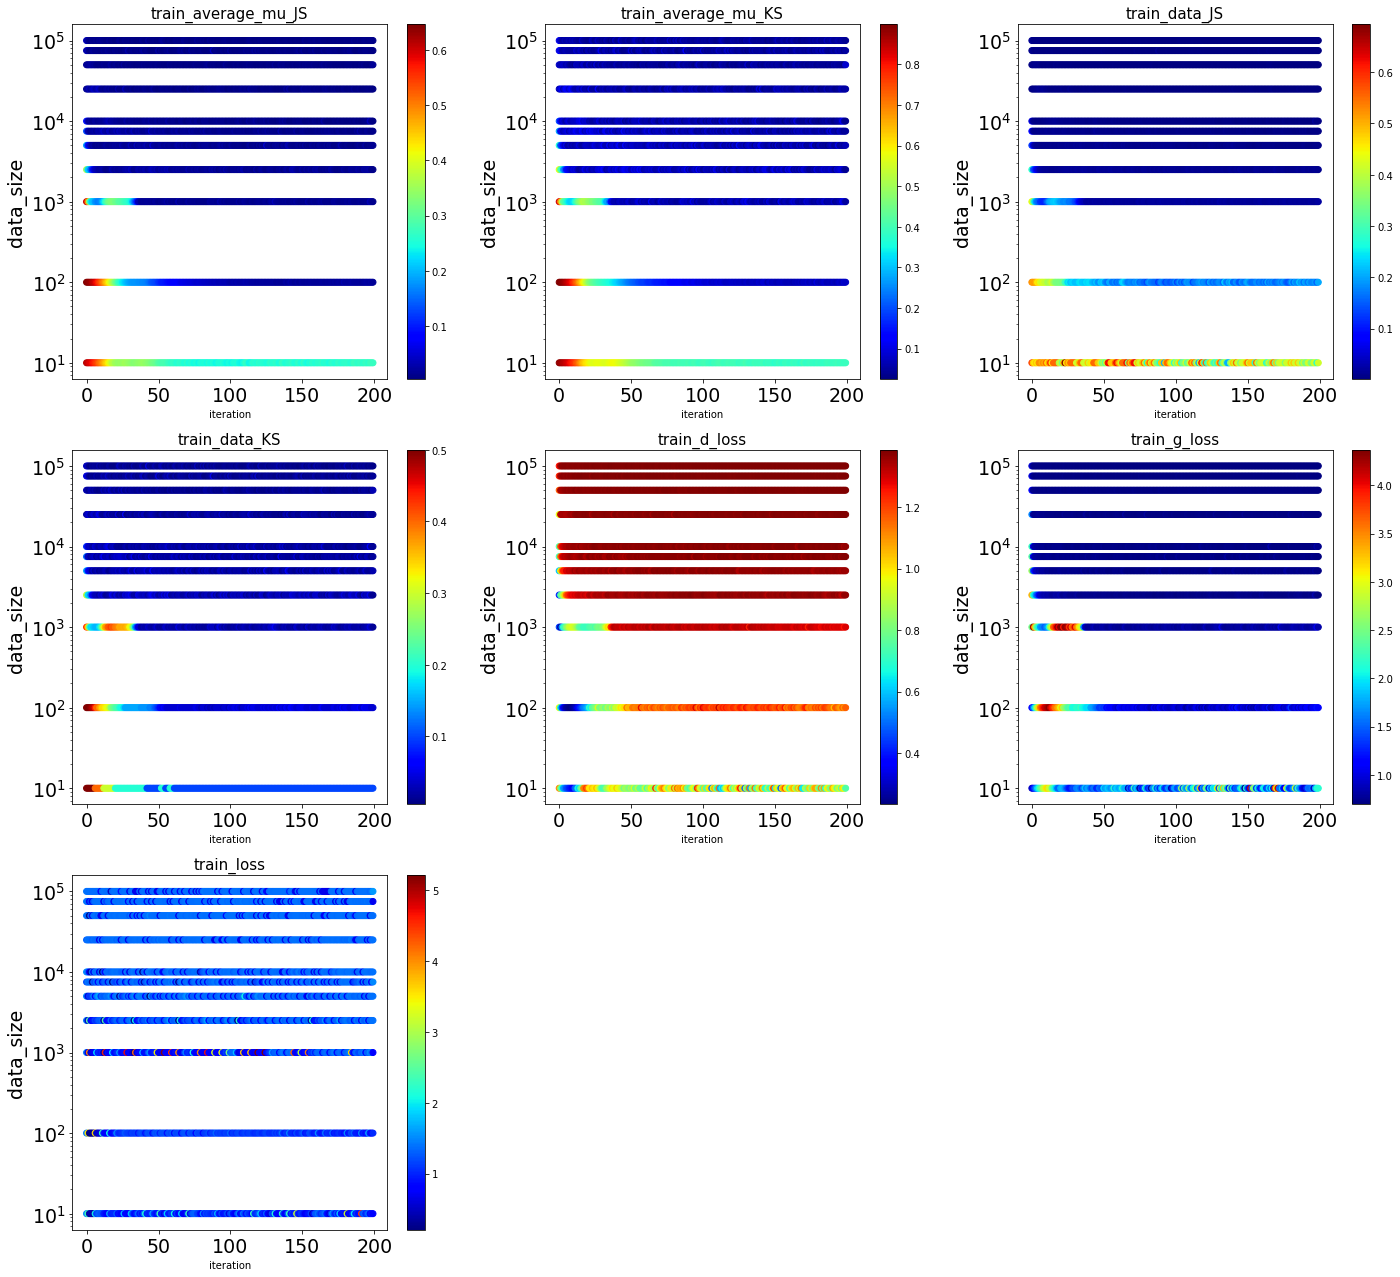

In [202]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')
plt.figure(figsize=(24,30))
for index, metric in enumerate(experiment.data['metrics']):
    plt.subplot(4,3, index + 1)

    data = np.array([size[0] for size in metrics[metric]])
    sizes = np.array([[int(size[1])] * data.shape[1] for size in metrics[metric]])

    iterations = np.repeat(np.array(mask).reshape(1,-1), sizes.shape[0], axis=0)
    plt.scatter(iterations, np.array(sizes), c=data, cmap=my_cmap);
    plt.colorbar()
    plt.yscale("log")
    plt.title(metric, fontsize=15)
    plt.xlabel("iteration")
    ax = plt.gca()
    ax.tick_params("both", labelsize=19)
    plt.ylabel("data_size", fontsize=19)


In [18]:
# metrics = list(zip(*exp.metrics_raw["train_average_mu_JS"]))
# plt.plot(*metrics);

# Test on mu outside of training domain

In [193]:
exp = comet_api.get("shir994/gan-data-size/913a22d185f44cbd8bea24f2d3362ff2")
hyper_params = {}
for param in exp.parameters:
    hyper_params[param["name"]] = param["valueMin"]

In [194]:
TASK = int(hyper_params['TASK'])
NOISE_DIM = int(hyper_params["NOISE_DIM"])

In [195]:
generator = Generator(NOISE_DIM, out_dim = 1).to(device)
if TASK == 4:
    discriminator = WSDiscriminator(in_dim=1).to(device)
else:
    discriminator = Discriminator(in_dim=1).to(device)

y_sampler = YModel()
fixed_noise = torch.Tensor(sample_noise(10000, NOISE_DIM)).to(device)
metric_calc = Metrics((-50, 50), 100)

In [196]:
import io
params = exp.get_asset(exp.asset_list[0]['assetId'])
state_dict = torch.load(io.BytesIO(params))

In [197]:
state_dict.keys()

dict_keys(['gen_state_dict', 'dis_state_dict', 'genopt_state_dict', 'disopt_state_dict', 'epoch'])

In [198]:
generator.load_state_dict(state_dict['gen_state_dict'])

/mnt/shirobokov/conda/envs/pytorch/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'mu=-0.000, x=1.000')

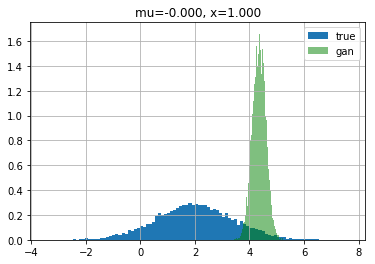

In [199]:
input_mu = torch.full(size=(10000, ), fill_value=-0.).to(device)
input_x = torch.full(size=(10000, ), fill_value=1.).to(device)

y_sampler.make_condition_sample({'mu': input_mu, 'X':input_x})
data = y_sampler.condition_sample().detach().cpu().numpy() 
            
plt.hist(data, bins=100, normed=True, label='true');
plt.hist(generator(fixed_noise, torch.stack([input_mu, input_x], dim=1)).detach().cpu().numpy(),
     bins=100, color='g', density=True, alpha=0.5, label='gan');
plt.grid()
plt.legend()
plt.title("mu={:.3f}, x={:.3f}".format(input_mu[0].item(), input_x[0].item()))

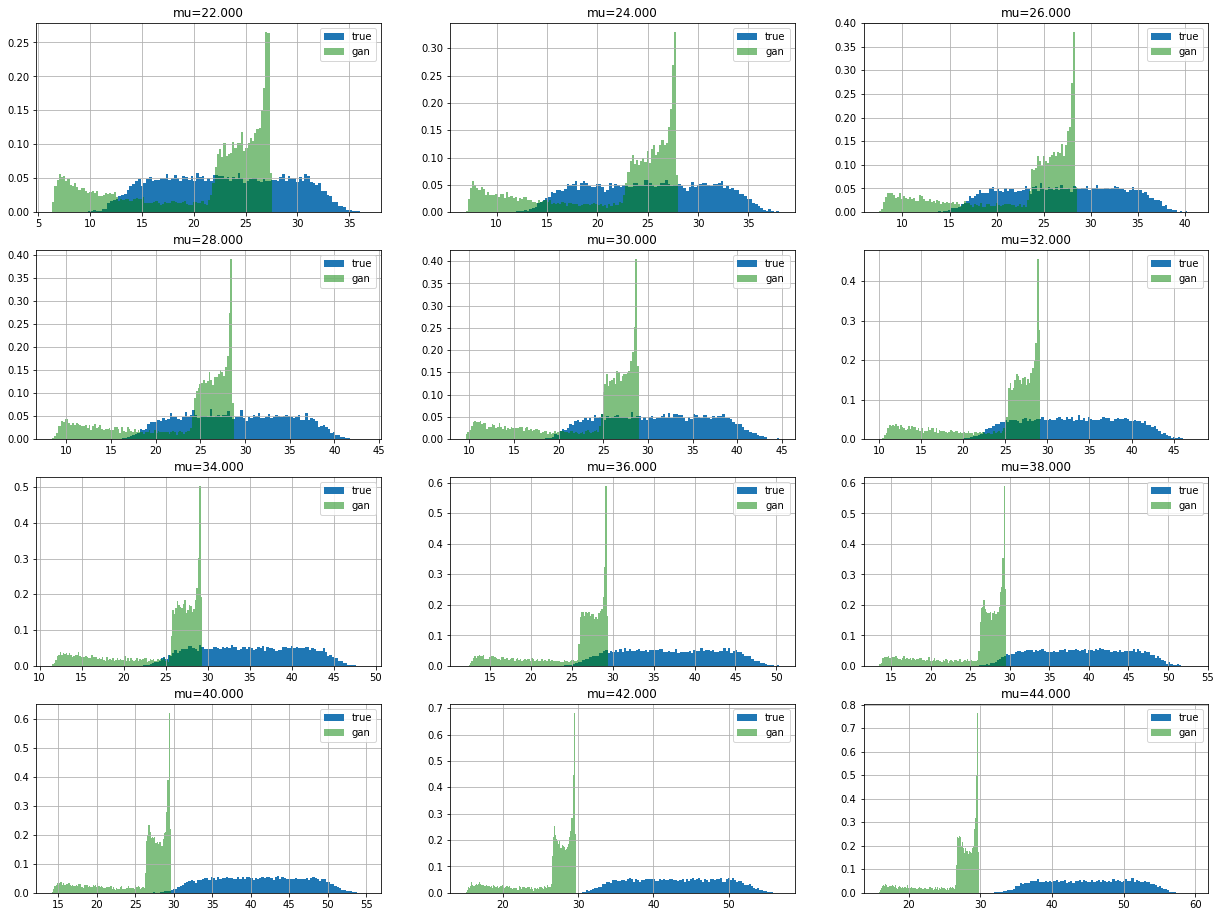

In [200]:
plt.figure(figsize=(21,16))
mu_range = list(range(22, 60, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        input_mu = torch.full(size=(10000, ), fill_value=mu_range[i*3 + j])#.to(device)
        input_x = y_sampler.x_dist.sample(input_mu.shape).to(device)

        y_sampler.make_condition_sample({'mu': input_mu})
        data = y_sampler.condition_sample().detach().cpu().numpy()

        input_mu = input_mu.to(device)

        plt.hist(data, bins=100, normed=True, label='true');
        plt.hist(generator(fixed_noise, torch.stack([input_mu, input_x], dim=1)).detach().cpu().numpy(),
             bins=100, color='g', density=True, alpha=0.5, label='gan');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}".format(input_mu[0].item()))

# Test optimisation

In [168]:
from copy import deepcopy

class InputOptimisation(nn.Module):
    def __init__(self, generator_model):
        super().__init__()
        self.gen = deepcopy(generator_model)
        for param in self.gen.parameters():
            param.requires_grad = False
        self.gen.eval()
       
    def forward(self, noise, inputs):
        return self.gen(noise, inputs)
    
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')    

In [175]:
io_model = InputOptimisation(generator)

lr = 0.1
sample_size = 1000


mu_optim = torch.tensor(30.)
mu_optim = mu_optim.repeat(sample_size).to(device)
mu_optim.requires_grad=True

In [176]:
%%time
n_iter = 30000
losses = []
m_vals = []
for _iter in range(n_iter):    
    noise = torch.Tensor(sample_noise(sample_size, NOISE_DIM)).to(device)
    x = y_sampler.x_dist.sample([mu_optim.shape[0]]).to(device)
    # Do an update
    data_gen = io_model(noise, torch.stack([mu_optim, x], dim=1))
    loss = R(data_gen)
    losses.append(loss.item())
    io_model.zero_grad()
    loss.backward()
    with torch.no_grad():
        mu_optim -= lr * mu_optim.grad.mean()
        mu_optim.grad.zero_()
    m_vals.append(mu_optim[0].item())

CPU times: user 1min 2s, sys: 3.91 s, total: 1min 6s
Wall time: 1min 5s


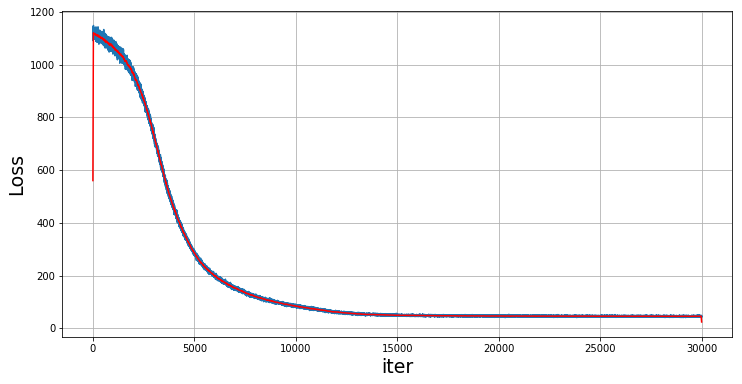

In [177]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.plot((movingaverage(losses, 50)), c='r')

Text(0.5, 0, 'iter')

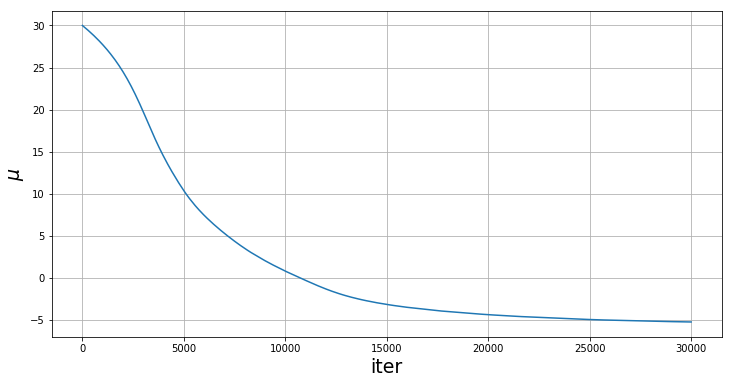

In [178]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)